# July 6, 2025 (AAPL)

In [1]:
ticker = 'AAPL'

In [2]:
# Imports
from call_peaks import call_peak_events
from get_sequences import build_feature_matrix, extract_context_sequences
from motif_analysis import cluster_and_extract_motifs, add_similarity_features
from train_model import train_optuna_xgboost_model
from optimize_thresholds import optimize_thresholds
from sklearn.metrics import precision_score, recall_score, auc
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import subprocess
import joblib
import shap

# Step 1: Call Peaks

In [3]:
# Run peak detection on the given ticker's volatility data.
# Returns residual volatility data, merged peak intervals, and a filtered set of summit points.
df_resid, df_merged_peaks, df_summits_filtered = call_peak_events(ticker)

# Preview the merged peak regions
df_merged_peaks.head()

,Merged_Start,Merged_End
0,1981-06-23 00:00:00-04:00,1981-06-30 00:00:00-04:00
1,1981-08-11 00:00:00-04:00,1981-08-21 00:00:00-04:00
2,1982-01-04 00:00:00-05:00,1982-01-08 00:00:00-05:00
3,1982-09-30 00:00:00-04:00,1982-10-12 00:00:00-04:00
4,1982-10-19 00:00:00-04:00,1982-10-23 00:00:00-04:00


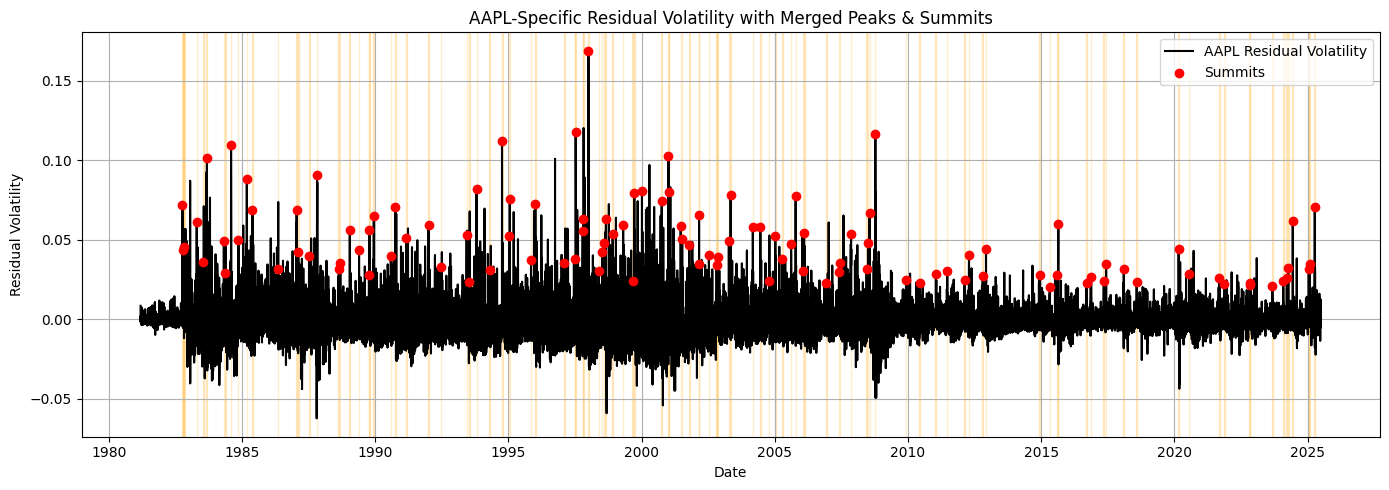

In [4]:
# Initialize a wide figure to visualize volatility
plt.figure(figsize=(14, 5))

# Plot the residual volatility over time
plt.plot(df_resid['Date'], df_resid['Residual'], color='black', label='AAPL Residual Volatility')

# Highlight summit points detected in filtered peaks
plt.scatter(df_summits_filtered['Summit_Date'], df_summits_filtered['Summit_Residual'], color='red', label='Summits', zorder=5)

# Optionally shade merged peak intervals for visual context
for _, row in df_summits_filtered.iterrows():
    plt.axvspan(row['Merged_Start'], row['Merged_End'], color='orange', alpha=0.2)

# Add labels, legend, and grid for clarity
plt.title('AAPL-Specific Residual Volatility with Merged Peaks & Summits')
plt.xlabel('Date')
plt.ylabel('Residual Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: Extract Sequence Features

In [5]:
# Construct the feature matrix (e.g., volatility windows, technical indicators) for the specified ticker
df_features = build_feature_matrix(ticker)

# Extract sequence data and associated feature scaling for regions around summit points
# Includes all sequences, scaled numeric features, and matched summits
df_sequences_all, df_scaled_features, df_summits = extract_context_sequences(
    df_features, df_summits_filtered
)

/n/scratch/users/r/ryc385/marketmotif/aws/get_sequences.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sentiment['date'] = pd.to_datetime(sentiment['date']).dt.tz_localize(None).dt.normalize()


In [6]:
# Display the first few rows of the constructed feature matrix
# Useful for confirming that feature extraction worked as expected
df_features.head()

,Date,Residual_Mean_5,Residual_Mean_10,Residual_Mean_20,Residual_Std_5,Residual_Std_20,Residual_Momentum_5,SP500_Vol_20,VIX_Mean_5,Volume_Mean_5,Volume_Mean_20,Volume_Std_20,RSI,MACD_Diff,BBW,Sentiment_Mean_3,Sentiment_Mean_7,Sentiment_Std_7,CPIFlag,FedFlag
0,1990-01-08,0.000264,-0.000989,0.004142,0.018688,0.020022,0.001852,0.004899,19.004,167518400.0,295001280.0,2.186772e+08,48.016367,0.004109,0.191600,0.050000,0.038571,0.016762,0,0
1,1990-01-09,-0.008334,-0.001021,0.003307,0.007860,0.020350,-0.042992,0.005005,19.996,148106560.0,286679120.0,2.234906e+08,46.045288,0.004050,0.147495,0.063333,0.044286,0.019881,0,0
2,1990-01-10,-0.002787,-0.000441,0.003005,0.017185,0.019955,0.027733,0.004784,20.846,146451200.0,264164320.0,2.070373e+08,38.642055,0.003179,0.133398,0.063333,0.047143,0.018898,0,0
3,1990-01-11,0.004286,0.003451,0.001358,0.023071,0.015440,0.035368,0.004813,21.012,144359040.0,223446160.0,1.037664e+08,33.316972,0.001892,0.144658,0.060000,0.052857,0.014960,0,0
4,1990-01-12,0.004992,0.002443,0.001272,0.022160,0.015542,0.003530,0.006194,21.918,154076160.0,212553040.0,9.657436e+07,33.316972,0.001080,0.149415,0.060000,0.057143,0.014960,0,0


# Step 3: Motif Clustering + Similarity Features

In [7]:
# Cluster sequences based on motif content and calculate enrichment scores.
# Also returns:
# - ctrl_labels: control group labels
# - centroid_motifs: representative motifs for each cluster
# - fdr_adj: adjusted false discovery rates for motif enrichment
df_enrichment, df_peak_clusters, ctrl_labels, centroid_motifs, fdr_adj = cluster_and_extract_motifs(
    df_sequences_all
)

# Add similarity-based features to the existing dataset.
# These features represent how closely each sequence resembles the enriched motifs.
df_model = add_similarity_features(
    df_features=df_features,
    df_scaled_features=df_scaled_features,
    centroid_motifs=centroid_motifs,
    fdr_adj=fdr_adj
)

In [8]:
# Display the enrichment scores for each cluster:
df_enrichment

,Cluster_ID,Peak_Count,Control_Count,Odds_Ratio,P_Value,FDR_Adjusted_P,Significant
0,0,3,0,inf,0.084610,0.190373,False
1,1,21,65,0.230769,1.000000,1.000000,False
2,2,1,0,inf,0.441748,0.567961,False
3,3,17,27,0.748749,0.842643,0.947973,False
4,4,3,0,inf,0.084610,0.190373,False
5,5,25,14,2.732684,0.004652,0.041864,True
6,6,1,0,inf,0.441748,0.567961,False
7,7,3,1,3.886364,0.228406,0.411130,False
8,8,17,8,3.072635,0.009563,0.043034,True


# Step 4: Model Training

[I 2025-07-06 15:32:29,017] A new study created in memory with name: no-name-c1330baa-c484-4721-b48a-122a03b52db3


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-06 15:32:29,166] Trial 0 finished with value: 0.7678659496019353 and parameters: {'max_depth': 4, 'learning_rate': 0.2302107875159783, 'subsample': 0.8652909541732087, 'colsample_bytree': 0.5438373813528865, 'gamma': 1.7720176956526386, 'reg_lambda': 9.032866384677144, 'reg_alpha': 0.1979968873749119}. Best is trial 0 with value: 0.7678659496019353.
[I 2025-07-06 15:32:29,352] Trial 1 finished with value: 0.7453089406073131 and parameters: {'max_depth': 5, 'learning_rate': 0.12013621299704637, 'subsample': 0.868445003693112, 'colsample_bytree': 0.7514034176482178, 'gamma': 3.6188041147269128, 'reg_lambda': 5.747910365517114, 'reg_alpha': 3.8733838293978518}. Best is trial 0 with value: 0.7678659496019353.
[I 2025-07-06 15:32:29,439] Trial 2 finished with value: 0.7442286465794603 and parameters: {'max_depth': 2, 'learning_rate': 0.419723057981523, 'subsample': 0.9148833885834006, 'colsample_bytree': 0.687243381888519, 'gamma': 4.188326793801419, 'reg_lambda': 1.3324487921562

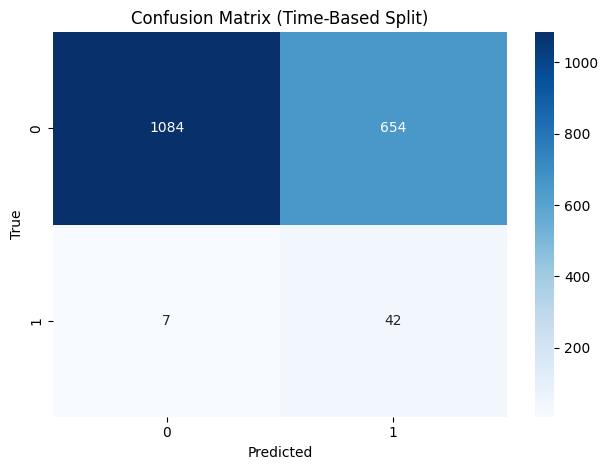


Best ROC AUC Score: 0.7748
Optimal Threshold (Youden’s J): 0.0125
Best Hyperparameters:
{'max_depth': 3, 'learning_rate': 0.08703694829912517, 'subsample': 0.8229066455004633, 'colsample_bytree': 0.4019668285859357, 'gamma': 1.7334645360536352, 'reg_lambda': 0.27747529808076477, 'reg_alpha': 2.465898459049244}


In [9]:
# Extract only the clusters that passed the significance threshold
significant_clusters = df_enrichment[df_enrichment['Significant']]['Cluster_ID'].tolist()

# Train an XGBoost model using Optuna for hyperparameter tuning,
results, df_test = train_optuna_xgboost_model(
    df_model=df_model,
    df_summits=df_summits_filtered,
    significant_clusters=significant_clusters,
    n_trials=100
)

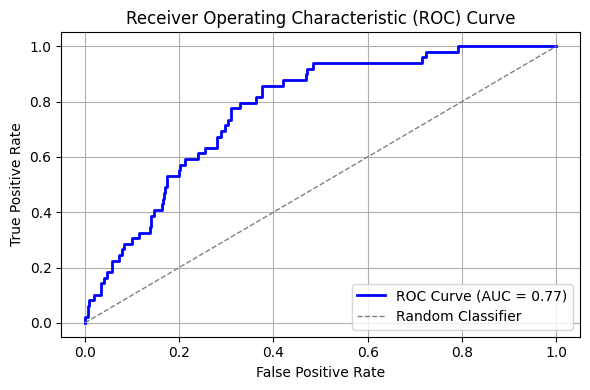

In [10]:
# Extract false positive and true positive rates from results
fpr = results['fpr']
tpr = results['tpr']

# Compute the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for the model
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Threshold Optimization

In [11]:
# Prepare data from model output
y_true = np.array(results['y_test'])
y_proba = np.array(results['y_proba'])
best_threshold = results['best_threshold']
roc_auc = results['roc_auc']
fpr = results['fpr']
tpr = results['tpr']

# Define target probability distributions for each true class:
target_matrix = np.array([
    [0.7, 0.2, 0.1],  # True 0
    [0.1, 0.2, 0.7]   # True 1
])

# Optimize thresholds (T1 and T2) to map probabilities into ternary bins
# (e.g., No Peak, Uncertain, Peak) to best match the target matrix
best_T1, best_T2, best_conf, best_mse = optimize_thresholds(y_true, y_proba, target_matrix, best_threshold)

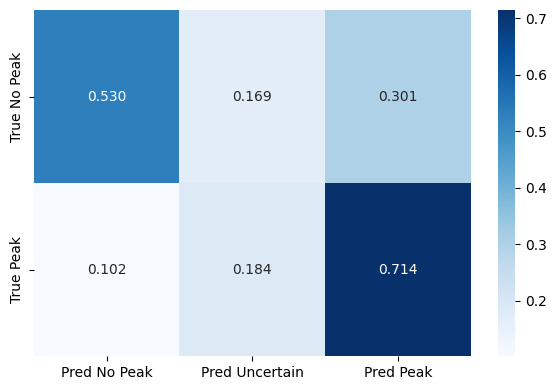

In [12]:
# Define labels for predicted and true classes
class_labels = ['Pred No Peak', 'Pred Uncertain', 'Pred Peak']
index_labels = ['True No Peak', 'True Peak']

# Create a DataFrame for the confusion matrix (normalized)
conf_df = pd.DataFrame(best_conf, index=index_labels, columns=class_labels)

# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_df, annot=True, fmt=".3f", cmap="Blues", cbar=True)
plt.tight_layout()
plt.show()

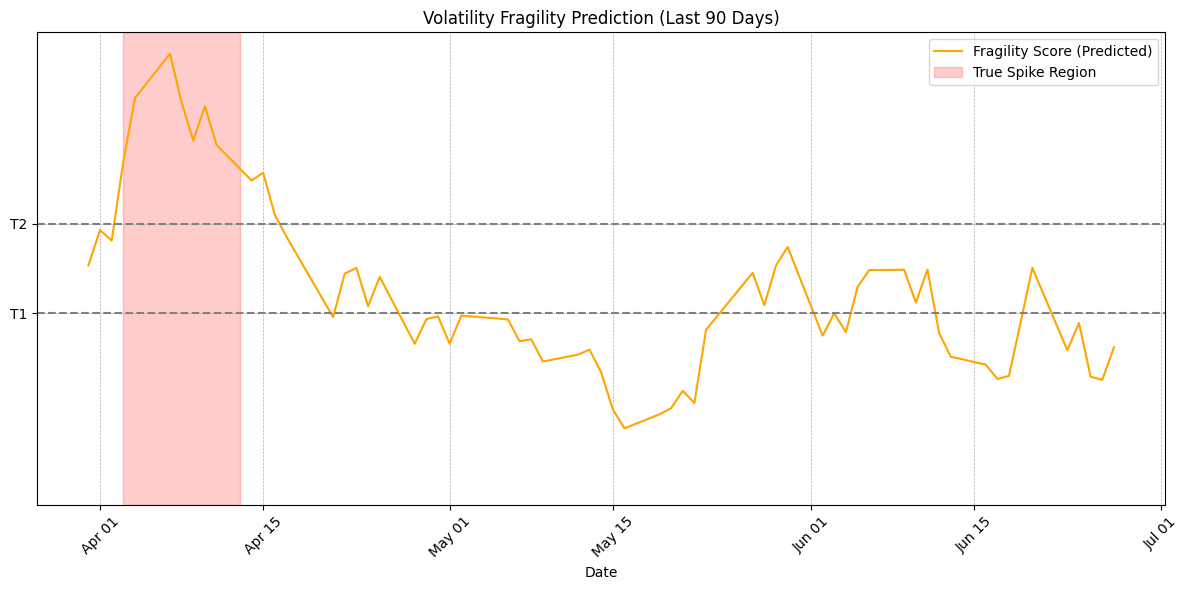

In [13]:
def plot_fragility_prediction(
    df_test: pd.DataFrame,
    y_proba: np.ndarray,
    y_true: np.ndarray,
    df_merged_peaks: pd.DataFrame,
    best_T1: float,
    best_T2: float,
    window_days: int = 90
):
    # Create a copy of the test DataFrame and add prediction probabilities and true labels
    df_test = df_test.copy()
    df_test['Fragility_Prob'] = y_proba
    df_test['True_Label'] = y_true

    # Filter to only include data from the last `window_days` days
    last_N_days = df_test['Date'].max() - pd.Timedelta(days=window_days)
    df_plot = df_test[df_test['Date'] >= last_N_days].copy()

    # Ensure date columns are timezone-naive for plotting
    df_merged_peaks['Merged_Start'] = pd.to_datetime(df_merged_peaks['Merged_Start']).dt.tz_localize(None)
    df_merged_peaks['Merged_End'] = pd.to_datetime(df_merged_peaks['Merged_End']).dt.tz_localize(None)
    last_N_days = last_N_days.tz_localize(None)

    # --- Plot setup ---
    plt.figure(figsize=(12, 6))

    # Line plot of predicted fragility scores over time
    sns.lineplot(data=df_plot, x='Date', y='Fragility_Prob', label='Fragility Score (Predicted)', color='orange')

    # Overlay true peak regions as shaded red intervals
    for _, row in df_merged_peaks.iterrows():
        if row['Merged_End'] >= last_N_days:
            plt.axvspan(row['Merged_Start'], row['Merged_End'], color='red', alpha=0.2, label='True Spike Region')

    # Add horizontal threshold lines for classification regions
    plt.axhline(best_T1, color='gray', linestyle='--')
    plt.axhline(best_T2, color='gray', linestyle='--')

    # Log-scale y-axis (base 2) for better resolution of low and high scores
    plt.yscale('log', base=2)
    midpoint = np.sqrt(best_T1 * best_T2)
    log_mid = np.log2(midpoint)
    y_vals = df_plot['Fragility_Prob'].replace(0, np.nan).dropna()
    raw_ymin = max(y_vals.min() * 0.7, 1e-8)
    raw_ymax = y_vals.max() * 1.3
    log_span = max(log_mid - np.log2(raw_ymin), np.log2(raw_ymax) - log_mid)
    plt.ylim(2 ** (log_mid - log_span), 2 ** (log_mid + log_span))
    plt.yticks([best_T1, best_T2], ['T1', 'T2'])

    # X-axis formatting and label cleanup
    plt.title(f"Volatility Fragility Prediction (Last {window_days} Days)")
    plt.xlabel("Date")
    plt.ylabel("")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%b %d"))

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys())

    # Add grid and tighten layout
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Call the plot function with thresholds and predictions
plot_fragility_prediction(
    df_test=df_test,
    y_proba=results['y_proba'],
    y_true=results['y_test'],
    df_merged_peaks=df_merged_peaks,
    best_T1=results['best_threshold'],
    best_T2=results['best_threshold'] * 3
)